<h1>A data perspective on three common Corona questions</h1>

<h2>Abstract</h2>

In this post we will

* Look at data to answer common Corona questions
* Combine and celebrate Open Data from different sources
* Analyze the data according to the CRISP-DM process

The [Robert Koch Institute (RKI)](https://www.rki.de/EN/Home/homepage_node.html) is the public health institute of Germany. The RKI is continuously monitoring the situation and publishes data about the pandemic in Germany. The [ard-data/2020-rki-archive](https://github.com/ard-data/2020-rki-archive) project cleans and preprocesses the daily RKI data to publish it in an aggregated and compressed (.json.bz) format. Each day has its own file, whichs tracks the status of all past and new Corona cases. For each case the geographical region, sex, agegroup, and the recency is recorded. For our analysis, and in order to link it to other data, we would like to have a convenient `.csv` file with aggregated data per day. Therefore, we compile the `corona-cases.csv` file in bash using the `compile.sh` script. Inside this script we decompress every day-file with `bzip2` and query it using the command-line JSON processor `jq`.

The RKI data is published under an open, CC-BY compatible license.
RKI (https://rki.de) DL-DE-BY-2.0 (https://www.govdata.de/dl-de/by-2-0)

<h3>Load libraries</h3>

We will use `sklearn` for modeling, and `seaborn` for visualization.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
# Setting seaborn as default style even if only matplotlib is used
sns.set()
# Draw images inline. For interactive, zoomable plots use %matplotlib notebook
%matplotlib inline
# Check PEP8 style
%load_ext pycodestyle_magic
# %pycodestyle_on

<h3>1. Gather the data</h3>

In this analysis we will look at new infection cases per day. We take a closer look at the urban and rural region of Karlsruhe (Landkreis ID [08215](https://de.wikipedia.org/wiki/Liste_der_Landkreise_in_Deutschland)). That is why we filter for `NeuerFall` and `IdLandkreis` when we query the daily `.json.bz` files for new cases per sex (`Geschlecht`) and age group (`Altersgruppe`) in Karlsruhe. For details on how we compile the `corona-cases.csv` file, with which we will work from now on, please have a look into the bash script `query.sh`. First, we read in the data as a dataframe, and then transform the date string in the index to a datetime object.

In [2]:
df = pd.read_csv("corona-cases.csv", index_col="date")
df.index = pd.to_datetime(df.index)

To follow the idea of Linked and Open data, we use the [Open Data portal of Karlsruhe](https://transparenz.karlsruhe.de/dataset/wetterdaten-13-monate-ruckwirkend/resource/85deef2a-90a5-4155-8d05-112c802ee72f), which provides historical weather data in a convenient `.csv` format. Here we merge the corona data with the weather data.

<p>The <a href="https://transparenz.karlsruhe.de/dataset/2e3545b3-b44e-492d-a5c9-f3a84f98e935">Wetterdaten 13 Monate rückwirkend</a>, <a href="https://karlsruhe.de">Stadt Karlsruhe</a> dataset is published under the licence <a href="https://www.govdata.de/dl-de/by-2-0">Datenlizenz Deutschland – Namensnennung – Version 2.0</a>.</p>

In [3]:
df_weather = pd.read_csv("weather.csv", index_col="Datum")
df_weather.index = pd.to_datetime(df_weather.index)
df = pd.concat([df, df_weather], axis=1)

<h3>2. Assess the data</h3>

The total number of `cases` per day is the larger of either the sum of all sexes, or the sum of all age groups. These two can be different in case of missing data in the RKI publication.

In [4]:
# Add total number of cases per day/row
cases = []

for row in df.iterrows():
    gender_sum = row[1]["male"] + row[1]["female"]
    age_sum = row[1]["a0_4"] + row[1]["a5_14"] + row[1]["a15_34"] + row[1]["a35_59"] + row[1]["a60_79"] + row[1]["a80"]
    if gender_sum > age_sum:
        cases.append(gender_sum)
    else:
        cases.append(age_sum)

df["cases"] = cases

Here we add the weekday for each date, reorder the feature columns, and have a first look at the data.

In [5]:
# Add weekday per row
i = 1 # 24-03-2020 was a tuesday
days = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
weekdays = []
for _ in range(0, 283):
    weekdays.append(days[i])
    if i == 6:
        i = 0
    else:
        i += 1

df["weekday"] = weekdays

In [6]:
# Reorder columns
column_names = ["weekday", 'cases', 'male', 'female', 'a0_4', 'a5_14', 'a15_34', 'a35_59', 'a60_79', 'a80', "Mittlere_Temperatur", "Temp_max", "Temp_min", "Regen_mm", "Strahlung", "Mittlere_Windgeschwindigkeit_km/h", "Windboen_km/h", "Richtung", "Mittlerer_Luftdruck_hPa", "Mittlere_Luftfeuchte", "Taupunkt", "Sonnenscheindauer_Min"]
df = df.reindex(columns=column_names)

In [7]:
df

,weekday,cases,male,female,a0_4,a5_14,a15_34,a35_59,a60_79,a80,...,Temp_min,Regen_mm,Strahlung,Mittlere_Windgeschwindigkeit_km/h,Windboen_km/h,Richtung,Mittlerer_Luftdruck_hPa,Mittlere_Luftfeuchte,Taupunkt,Sonnenscheindauer_Min
2020-03-24,tue,21.0,12,9,0,0,9,9,3,0,...,-1.35,0.00,219.08,10.91,27.90,72,1014.57,32.29,-9.35,620
2020-03-25,wed,11.0,6,5,0,1,3,5,2,0,...,-0.70,0.00,216.90,12.78,31.68,43,1008.23,33.65,-9.10,620
2020-03-26,thu,11.0,6,5,0,1,3,5,2,0,...,1.06,0.00,206.18,11.85,28.80,47,1002.89,41.96,-3.39,620
2020-03-27,fri,15.0,9,6,0,0,3,5,6,1,...,3.22,0.00,208.68,6.32,18.78,95,1000.80,46.93,1.79,620
2020-03-28,sat,12.0,6,6,0,0,4,5,2,1,...,4.39,0.07,206.78,6.82,61.20,131,1002.32,48.66,1.92,610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,sun,12.0,6,6,0,1,4,3,4,0,...,-0.62,0.40,20.40,8.89,33.60,143,984.01,68.10,2.48,10
2020-12-28,mon,15.0,7,8,0,0,3,4,5,3,...,2.29,7.44,18.78,8.82,34.86,155,966.63,81.74,3.89,30
2020-12-29,tue,23.0,11,12,1,3,5,9,4,1,...,1.39,9.14,19.83,10.45,47.45,193,976.31,82.21,2.86,50
2020-12-30,wed,26.0,12,14,3,2,6,8,5,2,...,2.93,0.04,15.30,6.98,18.72,216,989.33,81.58,2.29,0


The dataset covers cases for 283 days. The records start at `24 Mar 2020` and end at `31 Dec 2020`. For daily publications, please visit the [ard-data](https://github.com/ard-data/2020-rki-archive) project. The 22 features include the total number of cases, the split for `male` and `female`, and the distribution for agegroups defined by the RKI. Furthermore, the weather features include temperature, rainfall, sunshine duration, humidity, wind, and much more.

<h3>3. Clean</h3>

Luckily, the ard-data project has done the major part of the RKI data cleaning as described in their repository.

Here, we check for missing values. The indices of both dataframes were transformed to datetime objects.

In [8]:
df.isna().sum()

weekday                              0
cases                                0
male                                 0
female                               0
a0_4                                 0
a5_14                                0
a15_34                               0
a35_59                               0
a60_79                               0
a80                                  0
Mittlere_Temperatur                  0
Temp_max                             0
Temp_min                             0
Regen_mm                             0
Strahlung                            0
Mittlere_Windgeschwindigkeit_km/h    0
Windboen_km/h                        0
Richtung                             0
Mittlerer_Luftdruck_hPa              0
Mittlere_Luftfeuchte                 0
Taupunkt                             0
Sonnenscheindauer_Min                0
dtype: int64

<h3>4. Analyze + 5. Model + 6. Visualize</h3>

We combine the steps for each question.

<h3>Q1: Do more cases occur in cold and wet weather?</h3>

If we look at weather proxies like daily average temperature, or daily average humidity, we can see an effect on the daily Corona cases. The figure below shows scatterplots and their associated linear regression for four different weather features. On average, we observe more Corona infections for colder days, and also for more humid days.

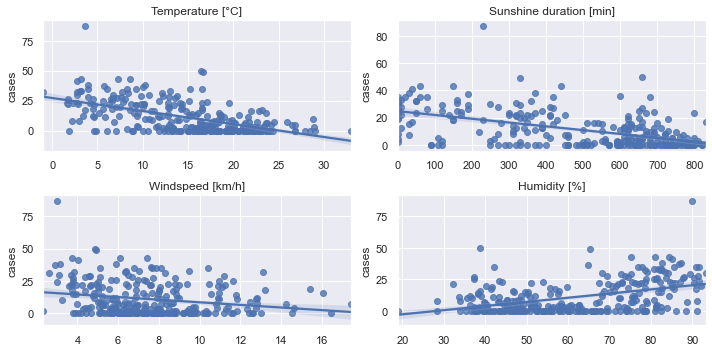

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharey=False)
# fig.suptitle('Cases over different weather conditions')

axes[0][0].set_title("Temperature [°C]")
axes[0][0].xaxis.label.set_visible(False)
sns.regplot(ax=axes[0][0], x=df["Mittlere_Temperatur"], y=df["cases"])
axes[0][1].set_title("Sunshine duration [min]")
axes[0][1].xaxis.label.set_visible(False)
sns.regplot(ax=axes[0][1], x=df["Sonnenscheindauer_Min"], y=df["cases"])
axes[1][0].set_title("Windspeed [km/h]")
axes[1][0].xaxis.label.set_visible(False)
sns.regplot(ax=axes[1][0], x=df["Mittlere_Windgeschwindigkeit_km/h"], y=df["cases"])
axes[1][1].set_title("Humidity [%]")
axes[1][1].xaxis.label.set_visible(False)
sns.regplot(ax=axes[1][1], x=df["Mittlere_Luftfeuchte"], y=df["cases"])

plt.tight_layout()
# fig.savefig("cases-weather.png")

<h3>Q2: Is there a weekly pattern for new Corona cases?</h3>

We can observe a weekly pattern of lows during the weekend and beginning of the week, and highs during the middle of the working week also in Karlsruhe. A variation of reported cases can especially seen for the `a35_59` agegroup, for people who are between 35 and 59 years old.

This can have multiple reasons:

* Less tests are carried out and reported during weekends.
* The data forwarding to the RKI may happen once each day at fixed times. While people are more flexible on weekends, they can make a test at any time of the day. In consequence, there is an increased chance the test results can still be reported within that day. On working days, when people can make a test mostly after work, the results might not be in time to be reported to the RKI on that very day. Such an accumulation of cases can be resolved during the working week.

Instead of looking at the absolute values, the relative values for age groups could also be of interest. However, we did not find Karlsruhe census data fitting the agegroups of the RKI.

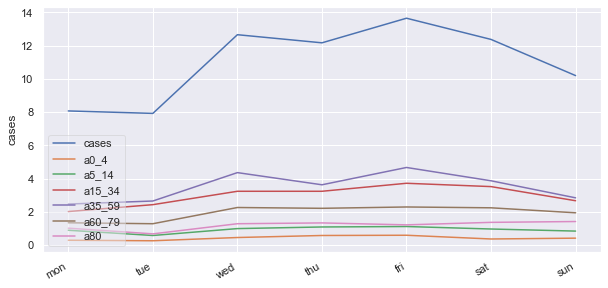

In [10]:
df_week = pd.DataFrame(df.query("cases > -1").groupby(['weekday']).mean()[["cases", 'a0_4', 'a5_14', 'a15_34', 'a35_59', 'a60_79', 'a80']])
df_week = df_week.reindex(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.set_ylabel("cases")
ax.plot(df_week)
ax.legend(["cases", 'a0_4', 'a5_14', 'a15_34', 'a35_59', 'a60_79', 'a80'], loc="lower left", framealpha=0.5)
fig.autofmt_xdate()
# fig.savefig("cases-week.png")

<h3>Q3: Do school lockdowns decrease children infections?</h3>

After the first initial lockdown, the schools relaxed the restrictions during summer. On 29.06.2020 (first vertical, black bar) the elementary schools opened for all grades without strict rules for the last 5 remaining weeks until the summer holidays. The second hard lockdown for schools started on 16.12.2020 (second vertical, black bar) and preponed the christmas holidays.

The below figure shows the number of new cases in the age group between 5 and 14 years old. While we can't see any trends before or after 29.06.2020 (left black line), we can delineate an increasing trend during autumn and winter in late 2020. The full lockdown on 16.12.2020 (right black line) for all schools in the state, as well as fewer tests during christmas time, might have lowered the case reports.

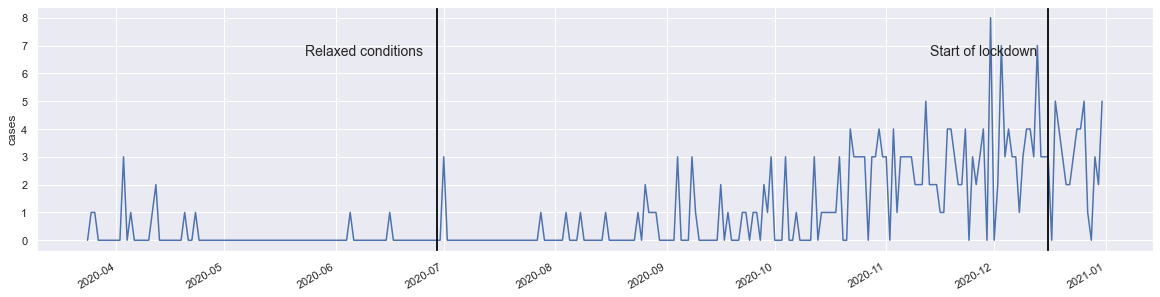

In [11]:
# 29.06.2020 Alle Klassen zurück, ohne Abstandsregeln, 4w bis Sommerferien
# 16.12.2020 Start des Lockdowns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.set_ylabel("cases")
ax.plot(df["a5_14"])
ax.axvline(pd.to_datetime("2020-06-29"), color='k', linewidth=2)
ax.text(0.24, 0.8, 'Relaxed conditions', transform=ax.transAxes, fontsize=14)
ax.axvline(pd.to_datetime("2020-12-16"), color='k', linewidth=2)
ax.text(0.8, 0.8, 'Start of lockdown', transform=ax.transAxes, fontsize=14)
fig.autofmt_xdate()
# fig.savefig("cases-school.png")

<h3>Summary</h3>

With this little analysis I want to celebrate and link publicly available data from different sources, and write my very first blog post. While presenting a data foundation for three common corona questions, I hope you, the reader, got motivated to search for local sources, open data platforms, and transparency to perform an analysis regarding your own questions.

<h3>Next Steps</h3>

* Include vaccination data (https://github.com/ard-data/2020-rki-impf-archive). First vaccination day was 28.12.2020
* Predict number of cases based on weather, vaccinations, and other
* Time series model and forecast
* Add more regional and related data features
* Fetch new data daily (CI, GitHub Actions?) and keep the statistics up-to-date

<h3>Bonus: Model</h3>

Let's try to predict cases based on this corona and weather data, as an exercise. Of course, the data at hand is not perfectly well suited for this task, but it is a good practice.

First, all categorical variables get 1-hot encoded. A binary feature column for each possible property value for all categorical variables is added to the dataframe. E.g. the `weekday` column is replaced with seven binary columns.

In [12]:
cat_vars = df.select_dtypes(include=['object']).columns # Subset to a dataframe only holding the categorical columns
for cat_var in cat_vars:
    dfcat = pd.get_dummies(df[cat_var])
    print(dfcat[["mon", "tue", "wed", "thu", "fri", "sat", "sun"]])

            mon  tue  wed  thu  fri  sat  sun
2020-03-24    0    1    0    0    0    0    0
2020-03-25    0    0    1    0    0    0    0
2020-03-26    0    0    0    1    0    0    0
2020-03-27    0    0    0    0    1    0    0
2020-03-28    0    0    0    0    0    1    0
...         ...  ...  ...  ...  ...  ...  ...
2020-12-27    0    0    0    0    0    0    1
2020-12-28    1    0    0    0    0    0    0
2020-12-29    0    1    0    0    0    0    0
2020-12-30    0    0    1    0    0    0    0
2020-12-31    0    0    0    1    0    0    0

[283 rows x 7 columns]


In [13]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not

    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating
    '''
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except Exception:
            continue
    return df

In [14]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test

    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
#     test_score = r2_score(y_test, y_test_preds)
#     train_score = r2_score(y_train, y_train_preds)
    test_score = mean_squared_error(y_test, y_test_preds)
    train_score = mean_squared_error(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [15]:
preds = [
    ["cases", 'Mittlere_Temperatur'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min"],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung', 'Mittlerer_Luftdruck_hPa'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung', 'Mittlerer_Luftdruck_hPa', 'Taupunkt'],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung', 'Mittlerer_Luftdruck_hPa', 'Taupunkt', "weekday"],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung', 'Mittlerer_Luftdruck_hPa', 'Taupunkt', "weekday", "a0_4"],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung', 'Mittlerer_Luftdruck_hPa', 'Taupunkt', "weekday", "a0_4", "a5_14"],
    ["cases", 'Mittlere_Temperatur', "Sonnenscheindauer_Min", 'Mittlere_Luftfeuchte', 'Temp_max', 'Temp_min', 'Regen_mm', 'Strahlung', 'Mittlere_Windgeschwindigkeit_km/h', 'Windboen_km/h', 'Richtung', 'Mittlerer_Luftdruck_hPa', 'Taupunkt', "weekday", "a0_4", "a5_14", "a80"],
]

train_mse = []
test_mse = []

for predictors in preds:
    test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df[predictors], "cases", cat_vars, dummy_na=False)
#     print(f"{train_score:.8f} Train MSE")
#     print(f"{test_score:.8f} Test MSE")
#     print(f"{(test_score - train_score):.8f}\n")
    train_mse.append(train_score)
    test_mse.append(test_score)

df_score = pd.DataFrame()
df_score["train_mse"] = train_mse
df_score["test_mse"] = test_mse

First, both train and test mean squared error remains on similar levels. Once we add the `agegroup` features to our prediction model, we can observe a sharp bend in both scores, and an "improvement" in our model.

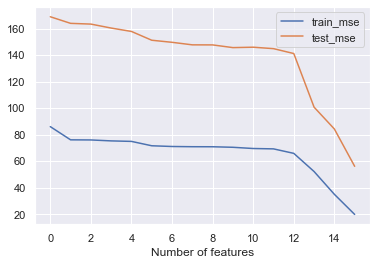

In [16]:
score_plot = df_score.plot()
_ = score_plot.set_xlabel("Number of features")